reference:
https://lifetimes.readthedocs.io/en/latest/Quickstart.html
https://github.com/CamDavidsonPilon/lifetimes/blob/master/lifetimes/fitters/beta_geo_fitter.py
https://towardsdatascience.com/predicting-customer-lifetime-value-with-buy-til-you-die-probabilistic-models-in-python-f5cac78758d9

In [1]:
# libraries import
from lifetimes.utils import summary_data_from_transaction_data, calibration_and_holdout_data
from lifetimes import BetaGeoFitter
from lifetimes.plotting import plot_calibration_purchases_vs_holdout_purchases, plot_period_transactions, \
                               plot_history_alive, plot_frequency_recency_matrix, plot_probability_alive_matrix

from matplotlib.pyplot import figure
from datetime import date, datetime

import pandas as pd

In [2]:
#INPUT
START_DATE_TRAIN = date(2014, 1, 1)
END_DATE_TRAIN = date(2022, 12, 31)
START_DATE_TEST = date(2023, 1, 1)
END_DATE_TEST = date(2023, 5, 31)
INPUT_FILEPATH = 'all_trx_2023-06-20.csv'
MINIMUM_TRX_PER_USER = 2

In [3]:
# read and summarize file
data = pd.read_csv(INPUT_FILEPATH)
data['created'] = pd.to_datetime(data['created'], format='mixed').dt.date
train_data = data[(data['created']>=START_DATE_TRAIN)&(data['created']<=END_DATE_TRAIN)]
test_data = data[(data['created']>=START_DATE_TEST)&(data['created']<=END_DATE_TEST)]
summary = summary_data_from_transaction_data(data, 'user_id', 'created', observation_period_end=END_DATE_TRAIN.strftime("%Y-%m-%d"))
summary = summary[summary['frequency']>=(MINIMUM_TRX_PER_USER-1)]

summary.head(5)

,frequency,recency,T
user_id,,,
1.0,3.0,1508.0,1556.0
4.0,2.0,2076.0,2084.0
5.0,10.0,573.0,607.0
6.0,1.0,1090.0,1314.0
13.0,7.0,2026.0,2172.0


In [4]:
# modelling

# ini bisa dituning
PENALIZER_COEF = 0.0

bgf = BetaGeoFitter(penalizer_coef=PENALIZER_COEF)
bgf.fit(summary['frequency'], summary['recency'], summary['T'])

<lifetimes.BetaGeoFitter: fitted with 548673 subjects, a: 0.65, alpha: 335.86, b: 2.09, r: 1.60>

<Axes: title={'center': 'Actual Purchases in Holdout Period vs Predicted Purchases'}, xlabel='Purchases in calibration period', ylabel='Average of Purchases in Holdout Period'>

<Figure size 800x480 with 0 Axes>

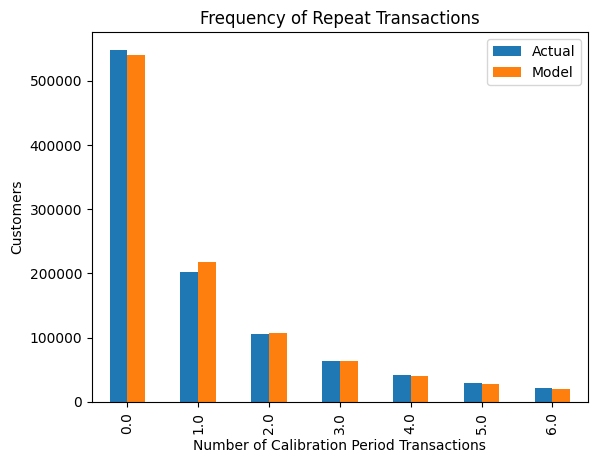

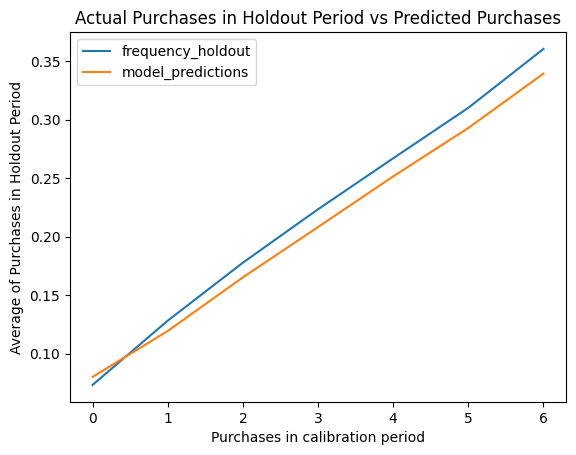

In [5]:
# check actual vs predicted purchase plot
summary_cal_holdout = calibration_and_holdout_data(data[data['created']>=START_DATE_TRAIN], 'user_id', 'created',
                                                   calibration_period_end=END_DATE_TRAIN.strftime("%Y-%m-%d"),
                                                   observation_period_end=END_DATE_TEST.strftime("%Y-%m-%d"))
                                                   
bgf_cal = BetaGeoFitter(penalizer_coef=0.0)
bgf_cal.fit(summary_cal_holdout['frequency_cal'], summary_cal_holdout['recency_cal'], summary_cal_holdout['T_cal'])

figure(figsize=(10, 6), dpi=80)
plot_period_transactions(bgf_cal)
plot_calibration_purchases_vs_holdout_purchases(bgf_cal, summary_cal_holdout)

d:\Stamp\trial propensity 2 buy\.venv\lib\site-packages\lifetimes\fitters\beta_geo_fitter.py:256: RuntimeWarning: overflow encountered in double_scalars
  denominator = 1 + (x > 0) * (a / (b + x - 1)) * ((alpha + T) / (alpha + recency)) ** (r + x)


<Axes: title={'center': 'Expected Number of Future Purchases for 1 Unit of Time,\nby Frequency and Recency of a Customer'}, xlabel="Customer's Historical Frequency", ylabel="Customer's Recency">

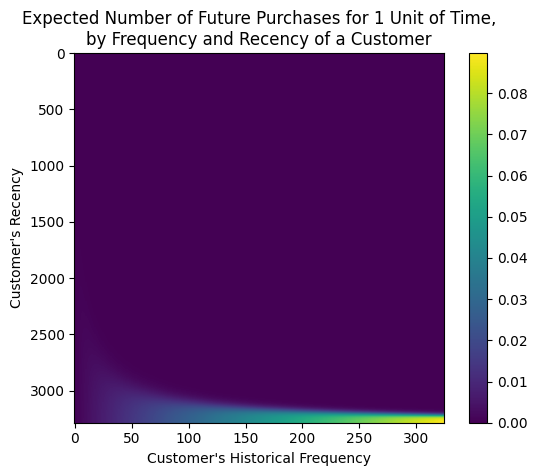

In [6]:
# check users collective behaviour
plot_frequency_recency_matrix(bgf)

<Axes: title={'center': 'Probability Customer is Alive,\nby Frequency and Recency of a Customer'}, xlabel="Customer's Historical Frequency", ylabel="Customer's Recency">

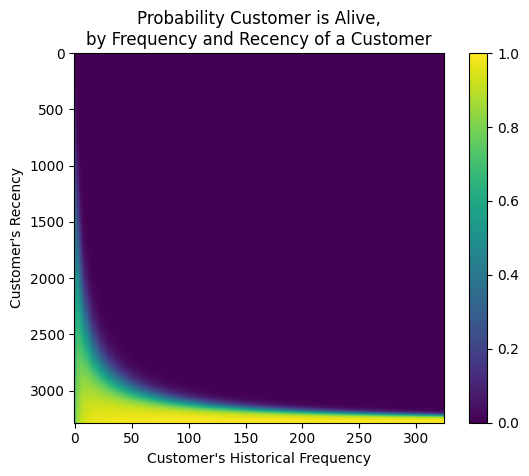

In [7]:
plot_probability_alive_matrix(bgf)

Best customer are the one frequently purchase and has high recency. The worst customer is the one frequently purchase in small time range.

<Axes: title={'center': 'History of P_alive'}, ylabel='P_alive'>

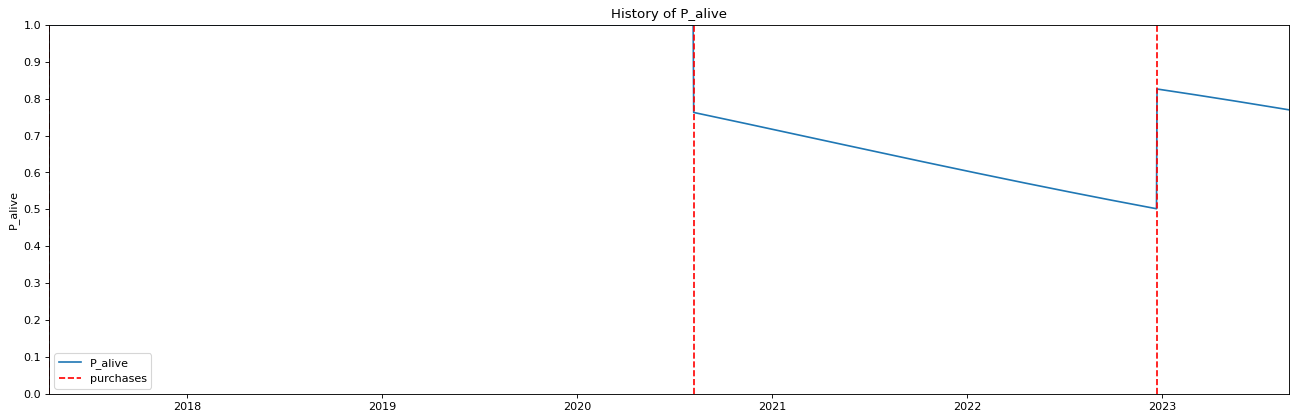

In [8]:
# sample customer purchase history
USER_ID = 4
DAYS_SINCE_FIRST_TRX = 2323

figure(figsize=(20, 6), dpi=80)
sp_trans = train_data.loc[train_data['user_id']==USER_ID]
plot_history_alive(bgf, DAYS_SINCE_FIRST_TRX, sp_trans, 'created')

In [9]:
# arrange data validation for prediction of future purchase on specific date
future_data = test_data.sort_values(by=['created', 'user_id'], ascending=True)
future_data_user = pd.DataFrame(future_data['user_id'].drop_duplicates())
future_data_user[['user_id', 'created']] = future_data[['user_id', 'created']]

current_data = train_data.sort_values(by=['created', 'user_id'], ascending=True)
current_data_user = pd.DataFrame(current_data['user_id'].drop_duplicates())
current_data_user[['user_id', 'created']] = current_data[['user_id', 'created']]

cek_data = pd.merge(current_data_user, future_data_user, how='left', left_on='user_id', right_on='user_id')
cek_data['created_y'][pd.isna(cek_data['created_y'])] = datetime.today().date()
cek_data['t'] = cek_data['created_y'] - cek_data['created_x']
cek_data = pd.merge(summary, cek_data, how='left', left_on='user_id', right_on='user_id')

cek_data.head(5)

,user_id,frequency,recency,T,created_x,created_y,t
0,1.0,3.0,1508.0,1556.0,2018-09-27,2023-04-02,"1648 days, 0:00:00"
1,4.0,2.0,2076.0,2084.0,2017-04-17,2023-09-24,"2351 days, 0:00:00"
2,5.0,10.0,573.0,607.0,2021-05-03,2023-09-24,"874 days, 0:00:00"
3,6.0,1.0,1090.0,1314.0,2019-05-27,2023-09-24,"1581 days, 0:00:00"
4,13.0,7.0,2026.0,2172.0,2017-01-19,2023-09-24,"2439 days, 0:00:00"


In [10]:
# predict probability of purchase on specific date
prob_life = []
for x in range(len(cek_data)):
    individual = cek_data.iloc[x]
    prob_life.append(bgf.conditional_probability_alive(individual['frequency'], individual['recency'], individual['t'].days)[0])
cek_data['prob_life'] = prob_life

In [21]:
cek_data.head()

,user_id,frequency,recency,T,created_x,created_y,t,prob_life
0,1.0,3.0,1508.0,1556.0,2018-09-27,2023-04-02,"1648 days, 0:00:00",0.817540
1,4.0,2.0,2076.0,2084.0,2017-04-17,2023-09-24,"2351 days, 0:00:00",0.762718
2,5.0,10.0,573.0,607.0,2021-05-03,2023-09-24,"874 days, 0:00:00",0.381144
3,6.0,1.0,1090.0,1314.0,2019-05-27,2023-09-24,"1581 days, 0:00:00",0.597908
4,13.0,7.0,2026.0,2172.0,2017-01-19,2023-09-24,"2439 days, 0:00:00",0.756266


In [11]:
# Results -> True and False Positive and Negative Value
tresholds = [0.5, 0.6, 0.7, 0.75, 0.8]

for treshold in tresholds:
    FP = cek_data[(cek_data['created_y']==datetime.today().date()) & (cek_data['prob_life']>=treshold)].shape[0]
    TN = cek_data[(cek_data['created_y']==datetime.today().date()) & (cek_data['prob_life']<treshold)].shape[0]
    TP = cek_data[(cek_data['created_y']!=datetime.today().date()) & (cek_data['prob_life']>=treshold)].shape[0]
    FN = cek_data[(cek_data['created_y']!=datetime.today().date()) & (cek_data['prob_life']<treshold)].shape[0]

    print(f'treshold probability: {treshold}')
    print(f'True Positive (predicted buy and in reality buy): {TP}')
    print(f'False Positive (predicted buy and in reality not buy): {FP}')
    print(f'True Negative (predicted not buy and in reality not buy): {TN}')
    print(f'False Negative (predicted not buy and in reality buy): {FN}')
    print(f'accuracy: {(TP + TN) / (TP + TN + FP + FN)}')
    print(f'recall: {TP / (TP + FN)}')
    print(f'precision: {TP / (TP + FP)}')
    print(f'f1 score: {2 * TP / (2 * TP + FP + FN)}')
    print(f'recall_neg: {TN / (TN + FP)}')  # ini perlu tinggi
    print(f'precision_neg: {TN / (TN + FN)}')
    print(f'f1 score neg: {2 * TN / (2 * TN + FP + FN)}')
    print(f'specificity: {TN / (TN + FP)}')
    print('')

treshold probability: 0.5
True Positive (predicted buy and in reality buy): 70826
False Positive (predicted buy and in reality not buy): 125737
True Negative (predicted not buy and in reality not buy): 327257
False Negative (predicted not buy and in reality buy): 24853
accuracy: 0.7255377975588374
recall: 0.7402460309994878
precision: 0.36032213590553663
f1 score: 0.4847078790865105
recall_neg: 0.7224312021792784
precision_neg: 0.9294169435687711
f1 score neg: 0.8129558417297641
specificity: 0.7224312021792784

treshold probability: 0.6
True Positive (predicted buy and in reality buy): 61861
False Positive (predicted buy and in reality not buy): 84779
True Negative (predicted not buy and in reality not buy): 368215
False Negative (predicted not buy and in reality buy): 33818
accuracy: 0.7838475740559495
recall: 0.6465473092319108
precision: 0.42185624659028914
f1 score: 0.5105749033299081
recall_neg: 0.8128474107824828
precision_neg: 0.9158825270562366
f1 score neg: 0.8612944386551535


Threshold 0.5-0.6 is considered enough for this data

In [18]:
# arrange data validation for prediction of number of future purchase on specific date range
future_purchase = pd.DataFrame(test_data.groupby('user_id')['created'].count()).rename(columns={'created': 'real_purchase'})

t = (END_DATE_TEST - END_DATE_TRAIN).days
data_purchase = summary.copy()
data_purchase['predicted_purchase'] = bgf.conditional_expected_number_of_purchases_up_to_time(t, summary['frequency'], summary['recency'], summary['T'])
data_purchase = pd.merge(data_purchase, future_purchase, how='left', left_on='user_id', right_on='user_id')
data_purchase.fillna(0, inplace=True)
data_purchase['predicted_purchase_rounded'] = data_purchase['predicted_purchase'].round()

In [20]:
data_purchase.head()

,frequency,recency,T,predicted_purchase,predicted_purchase_rounded,real_purchase
user_id,,,,,,
1.0,3.0,1508.0,1556.0,0.303634,0.0,1.0
4.0,2.0,2076.0,2084.0,0.181518,0.0,0.0
5.0,10.0,573.0,607.0,1.623005,2.0,0.0
6.0,1.0,1090.0,1314.0,0.158938,0.0,0.0
13.0,7.0,2026.0,2172.0,0.447586,0.0,0.0


In [19]:
# Results -> True and False Positive and Negative Value
True_ = data_purchase[data_purchase['predicted_purchase_rounded']==data_purchase['real_purchase']]
False_ = data_purchase[data_purchase['predicted_purchase_rounded']!=data_purchase['real_purchase']]

TP = True_[True_['real_purchase']!=0].shape[0]
TN = True_[True_['real_purchase']==0].shape[0]
TP_ = False_[(False_['real_purchase']>0) & (False_['predicted_purchase_rounded']>0)].shape[0]
FP = False_[(data_purchase['real_purchase']==0) & (data_purchase['predicted_purchase_rounded']>0)].shape[0]
FN = False_[(data_purchase['real_purchase']>0) & (data_purchase['predicted_purchase_rounded']==0)].shape[0]

print(f'True Positive (predicted buy and in reality buy): {TP + TP_}')
print(f'True Positive and Accurate (predicted buy and in reality buy with the predicted value): {TP}')
print(f'True Positive and Not Accurate (predicted buy and in reality buy with false predicted value): {TP_}')
print(f'False Positive (predicted buy and in reality not buy): {FP}')
print(f'True Negative (predicted not buy and in reality not buy): {TN}')
print(f'False Negative (predicted not buy and in reality buy): {FN}')
print(f'accuracy overall: {(TP + TP_ + TN)/(TP + TP_ + TN + FP + FN)}')
print(f'accuracy with correct predicted value: {(TP + TN) / (TP + TP_ + TN + FP + FN)}')

C:\Users\risma\AppData\Local\Temp\ipykernel_14328\1328246784.py:8: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  FP = False_[(data_purchase['real_purchase']==0) & (data_purchase['predicted_purchase_rounded']>0)].shape[0]
C:\Users\risma\AppData\Local\Temp\ipykernel_14328\1328246784.py:9: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  FN = False_[(data_purchase['real_purchase']>0) & (data_purchase['predicted_purchase_rounded']==0)].shape[0]


True Positive (predicted buy and in reality buy): 35370
True Positive and Accurate (predicted buy and in reality buy with the predicted value): 17876
True Positive and Not Accurate (predicted buy and in reality buy with false predicted value): 17494
False Positive (predicted buy and in reality not buy): 40477
True Negative (predicted not buy and in reality not buy): 412517
False Negative (predicted not buy and in reality buy): 60309
accuracy overall: 0.8163095322714987
accuracy with correct predicted value: 0.7844253316638508


In [22]:
# export to csv
OUTPUT_FILEPATH = 'predicted_buying_user.csv'

data_purchase.reset_index()[['user_id', 'frequency', 'recency', 'T', 'predicted_purchase', 'predicted_purchase_rounded']].to_csv(OUTPUT_FILEPATH, index=False)